# Direct method
$$
    \left\{
    \begin{array}{l}
        \displaystyle \min - x_1(8), \\[0.5em]
        \dot{x}_1(t) = x_2(t) + \cos(u(t)), \; \text{for a.e. } t\in [0,8],\\[0.5em]
        \dot{x}_2(t) = \sin(u(t)),  \; \text{for a.e. } t\in [0,8], \\[0.5em]
        u(t) \in [-\frac{\pi}{2}, \frac{\pi}{2}], \; \text{for a.e. } t\in [0,8], \\[0.5em]
        x(0) = 0_{\mathbb{R}^2}, \quad x_2(8) = 4,\\[0.5em]
        \{x \mid 3 < x_1 < 7 \} \text{ and } \{x \mid 16 < x_1 < 26 \} \text{ are loss control regions.}
    \end{array}
    \right.
$$

In [112]:
using JuMP  
using Ipopt
using Plots
using Plots.PlotMeasures

In [114]:
mutable struct Direct
  t; x1; x2 ; u ; a ; b ; p1 ; p2 
end

In [134]:
function ZERMELO(x0; solution=[], nsteps=500, display=true)
    
    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-8)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",1000)
    
    N  = nsteps     # Grid size
    
    @variables(sys, begin
        x1[1:N+1]                 # x1
        x2[1:N+1]                 # x2
        -π/2 ≤ u[1:N+1] ≤ π/2     # Control
        -π/2 ≤  a       ≤ π/2 
        -π/2 ≤  b       ≤ π/2 

        end)
    
    Δt  =  8.0/(N+1) ; 
    
    # Objective
    @NLobjective(sys, Max, x1[N+1])
    
    # Boundary constraints
    @constraints(sys, begin
        con_x10, x1[1]   == x0[1]                #initial condition
        con_x20, x2[1]   == x0[2]                #initial condition
        con_x2f, x2[N+1] == 4.0                  #final condition 
        end)
    
    # Dynamics


    @NLexpression(sys, dx1[j=1:N+1], x2[j] + cos(u[j])  + (x1[j] > 3)*(x1[j] < 7)*(cos(a) - cos(u[j])) + (x1[j] > 16)*(x1[j] < 23)*(cos(b) - cos(u[j])))

    
    @NLexpression(sys, dx2[j=1:N+1], sin(u[j]) + (x1[j] > 3)*(x1[j] < 7)*(sin(a) - sin(u[j])) + (x1[j] > 16)*(x1[j] < 23)*(sin(b) - sin(u[j])))

    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j]) 
    end);
    
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end
        
    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end    
        
    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    u  = value.(u)[:]
    a  = value.(a)
    b  = value.(b)
    t  = (0:N) * value.(Δt)
    
    
    px10 =   dual(con_x10)
    px20 =   dual(con_x20)
    px2f = - dual(con_x2f)  # Modification : changement de signe

    # keep original signs for now
    sign = 1
    
     px1 = [ dual(con_dx1[i]) for i in 1:N ]
     px2 = [ dual(con_dx2[i]) for i in 1:N ]

     px1 = sign * [px10; (px1[1:N-1]+px1[2:N])/2.]; # We add the multiplier from the limit conditions
     px2 = sign * [px20; (px2[1:N-1]+px2[2:N])/2.; px2f]; # We add the multiplier from the limit conditions
    
     p1 = - [px10; px1[1:N] ]; # We add the multiplier from the limit conditions
     p2 = - [px20; px2[1:N-1]; px2f]; # We add the multiplier from the limit conditions

    return Direct(t, x1, x2, u, a, b, p1, p2)
        
end;

In [135]:
# Resolution
x0  = [0.0; 0.0]

sol_direct = ZERMELO(x0);

Solving...
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     8003
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     8000

Total number of variables............................:     1505
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      503
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1003
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 9.16e-03  -1.0 0.00e+00    -  0.00e+00

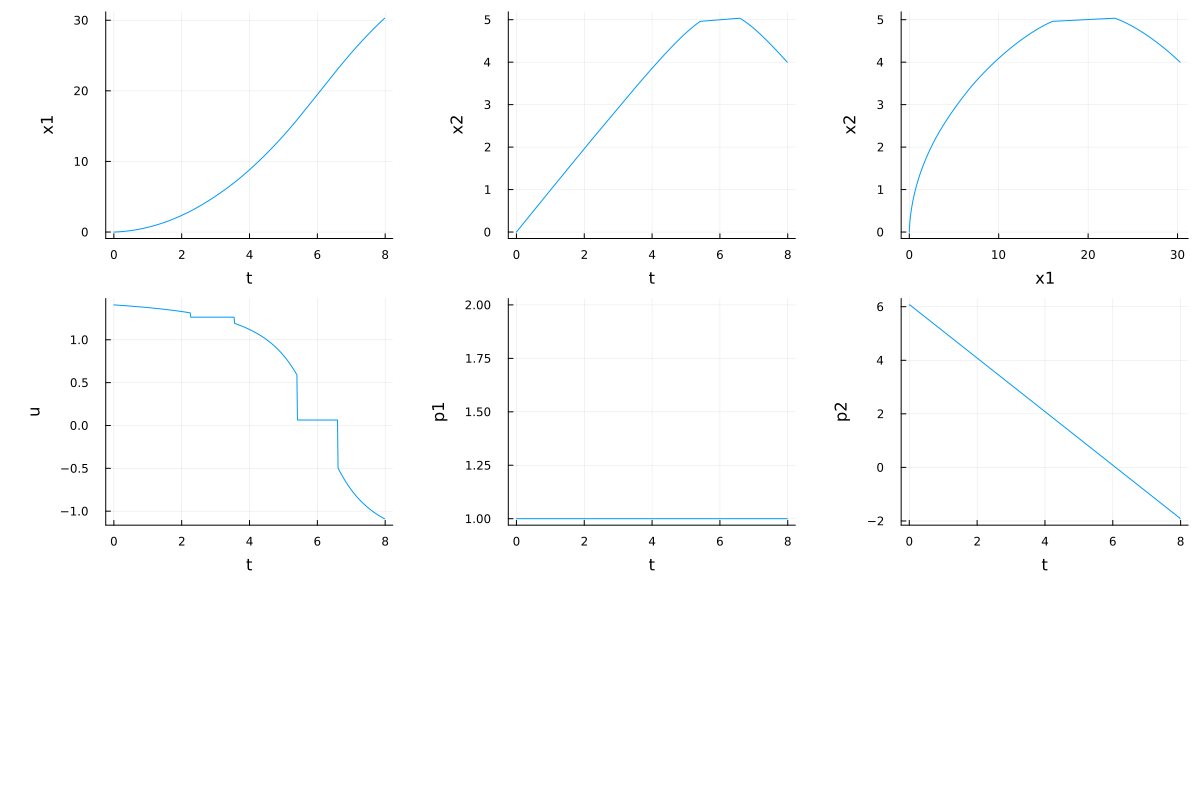

In [153]:
# Plots
t  = sol_direct.t
x1 = sol_direct.x1
x2 = sol_direct.x2
u  = sol_direct.u
a  = sol_direct.a
b  = sol_direct.b
p1  = sol_direct.p1
p2  = sol_direct.p2

idx1 = findall(abs.(x1 .- 3.0) .< 0.02)
idx2 = findall(abs.(x1 .- 7.0) .< 0.02)

idx3 = findall(abs.(x1 .- 16.0) .< 0.04)
idx4 = findall(abs.(x1 .- 23.0) .< 0.047)

 t1 = t[idx1]
 t2 = t[idx2]
 t3 = t[idx3]
 t4 = t[idx4]
 u1 = copy(u) 
 u1[t1 .<= t .<= t2] .= a
 u1[t3 .<= t .<= t4] .= b

x1_plot   = plot(t, x1,  xlabel = "t", ylabel = "x1",  legend = false)
x2_plot   = plot(t, x2,  xlabel = "t", ylabel = "x2",  legend = false)
p1_plot   = plot(t, p1,  xlabel = "t", ylabel = "p1",  legend = false)
p2_plot   = plot(t, p2,  xlabel = "t", ylabel = "p2",  legend = false)

u_plot    = plot(t, u1,   xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false)

plot(x1_plot, x2_plot, x1x2_plot, u_plot, p1_plot ,p2_plot , layout = (3,3), size=(1200,800), left_margin=10mm)

# Indirect method

In [154]:
using NLsolve
using Plots
using Plots.PlotMeasures
include("flow.jl");
using LinearAlgebra;

In [193]:
# Dynamics
function F(x, u)
    return [ x[2] + cos(u[1]), sin(u[1]) ]
end

function G(λ)
    return [  sin(λ), - cos(λ) ]
end

# Hamiltonians: permanent region
H1(x, u, p)  = p' * F(x, u)               # pseudo-Hamiltonian
u11(x, p)    = atan(p[2]/p[1])
Hc(x, p)     = H1(x, u11(x, p) , p )      # control

# Flows
fc  = Flow(Hc);

# Hamiltonians: control loss region 1
H2(x, a, y, p)   = p' * F(x, a)   + y* p' *G(a)          # pseudo-Hamiltonian
Hcl1(X, P)       = H2(X[1:2], X[3], X[4], P[1:2])           # control loss1

fcl1  = Flow(Hcl1);

# Hamiltonians: control loss region 1
H3(x, b, y, p)   = p' * F(x, b)   + y* p' *G(b)          # pseudo-Hamiltonian
Hcl2(X, P)       = H3(X[1:2], X[3], X[4], P[1:2])           # control loss2

# Flows
fcl2  = Flow(Hcl2);

In [194]:
t0  = 0.0
tf  = 8.0
x2f = 4.0
x0  = [0.0; 0.0]



# Shooting function
function shoot(p0, tt1, tt2, tt3, tt4, a, b) 
    
    pa0    = 0.0 
    pb0    = 0.0 
    py0    = 0.0
    
    x1, p1 = fc(t0, x0, p0, tt1)
    
    X2, P2 = fcl1(tt1, [x1; a ; 0.0], [p1; pa0 ; py0], tt2) # flow augmenté
    
    x3, p3 = fc(tt2, X2[1:2], P2[1:2], tt3)

    X4, P4 = fcl2(tt3, [x3; b ; 0.0], [p3; pb0 ; py0], tt4)
    
    xf, pf = fc(tt4, X4[1:2], P4[1:2], tf)


    s = zeros(eltype(p0), 8)
    s[1]  = xf[2] - x2f  # target
    s[2]  = pf[1] - 1.0  # transversality condition
    s[3]  = x1[2] - 3.0  # first crossing 
    s[4]  = X2[2] - 7.0  # second crossing 
    s[5]  = x3[2] - 16.0 # first crossing 
    s[6]  = X4[2] - 23.0 # second crossing 
    s[7]  = P2[3]        # averaged gradient condition1
    s[8]  = P4[3]        # averaged gradient condition2

    return s

end;

In [195]:
S(ξ) = shoot(ξ[1:2], ξ[3], ξ[4], ξ[5], ξ[6], ξ[7], ξ[8]) ;

In [199]:
ξ_guess = [p1[1], p2[1], t1[1], t2[1],t3[1],t4[1], a, b]  # initial guess

8-element Vector{Float64}:
 1.0
 6.0676201238339695
 2.2674650698602794
 3.5449101796407185
 5.413173652694611
 6.594810379241517
 1.263714259699409
 0.063542448949981

In [200]:
println("Initial value of shooting:\n", S(ξ_guess), "\n\n") ;

Initial value of shooting:
[-0.014109834557941348, 0.0, -0.7800538321780985, -3.5623680453310387, -11.043802014866973, -17.968768440417122, -0.0030829946885782542, 1.9711778437851926e-12]




In [201]:
# Solve

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    pp0 = indirect_sol.zero[1:2]
    tt1 = indirect_sol.zero[3]
    tt2 = indirect_sol.zero[4]
    tt3 = indirect_sol.zero[5]
    tt4 = indirect_sol.zero[6]
    aa  = indirect_sol.zero[7]
    bb  = indirect_sol.zero[8]

else
    error("Not converged")
end;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.796877e+01              NaN
     1     3.192643e+01     9.063162e-16
     2     1.557717e+01     6.420082e+00
     3     2.685956e+01     1.017536e-15
     4     1.333626e+01     5.792159e+00
     5     5.133089e+00     9.399419e+00
     6     2.142576e+01     1.110223e-16
     7     2.142576e+01     0.000000e+00
     8     2.142576e+01     0.000000e+00
     9     9.719265e+00     0.000000e+00
    10     3.985982e+00     3.247728e+00
    11     2.514178e+01     0.000000e+00
    12     1.653823e+01     0.000000e+00
    13     4.125091e+00     4.436012e+00
    14     5.058308e+00     5.551115e-17
    15     3.993860e+00     6.064821e+00
    16     6.192620e+00     2.220446e-16
    17     4.014287e+00     3.156773e+00
    18     3.999270e+00     2.745699e+00
    19     4.001087e+00     0.000000e+00
    20     3.998995e+00     3.518905e+00
    21     3.999692e+00     0.000000e+00
    22     3.99775

LoadError: Not converged